<a href="https://colab.research.google.com/github/kussy29/machine_learning/blob/main/lab10_convolutional_neural_network_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10 - Convolutional Neural Network, CNN

### Author: Szymon Nowakowski

# Presentation on Convolutional Layers
--------------------

We shall start off by going through a [short presentation on convolusional layers](https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/convolutional_layers.pdf). It is best to first download it and then go through it in a slide-show layout.

# Reading MNIST Dataset
----------------------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.54MB/s]


# Tensor Sizes
-------------------

Recall:
- Batched labels are of order one. The first (and only) index is a sample index within a batch.
- Image batches have order 4. The first order is a batch order, but a second order has dimensionality of 1 and thus it can be indexed by 0 only.
  - This index represents a Channel number inserted here by `ToTensor()` transformation, always 0.
  - This singleton order should be retained because we want to use convolutional layers, which explicitly require this order. For RGB images we have 3 channels, for B&W images we have only one channel.


# CNN Definition
-----------------



## Task

Your job now is to code the definition of the LeNet5 neural network. You can find the definition [here](https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg).


In [22]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.dropout = torch.nn.Dropout(0.05)
        self.relu = torch.nn.ReLU()
        self.max_pool2d = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(256, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = torch.flatten(x,1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)


        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [23]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3005523681640625
epoch: 0 batch: 1 current batch loss: 2.2907814979553223
epoch: 0 batch: 2 current batch loss: 2.2759127616882324
epoch: 0 batch: 3 current batch loss: 2.2632546424865723
epoch: 0 batch: 4 current batch loss: 2.24397349357605
epoch: 0 batch: 5 current batch loss: 2.22074556350708
epoch: 0 batch: 6 current batch loss: 2.195930004119873
epoch: 0 batch: 7 current batch loss: 2.168405532836914
epoch: 0 batch: 8 current batch loss: 2.1352028846740723
epoch: 0 batch: 9 current batch loss: 2.094796895980835
epoch: 0 batch: 10 current batch loss: 2.0375325679779053
epoch: 0 batch: 11 current batch loss: 1.9857971668243408
epoch: 0 batch: 12 current batch loss: 1.926395058631897
epoch: 0 batch: 13 current batch loss: 1.8585082292556763
epoch: 0 batch: 14 current batch loss: 1.7822847366333008
epoch: 0 batch: 15 current batch loss: 1.6762099266052246
epoch: 0 batch: 16 current batch loss: 1.6049432754516602
epoch: 0 batch: 

# Testing
----------------------

In [4]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9839


In [49]:
trainset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

### Task 1


In [38]:
import matplotlib.pyplot as plt
def display_numbers(inputs):
  figure = plt.figure(figsize=(50, 5))
  for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.title(str(labels[i]))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    input=inputs[i].squeeze(0)
    #input*=0.3081
    #input+=0.1307
    #input*=255
    plt.imshow(input)

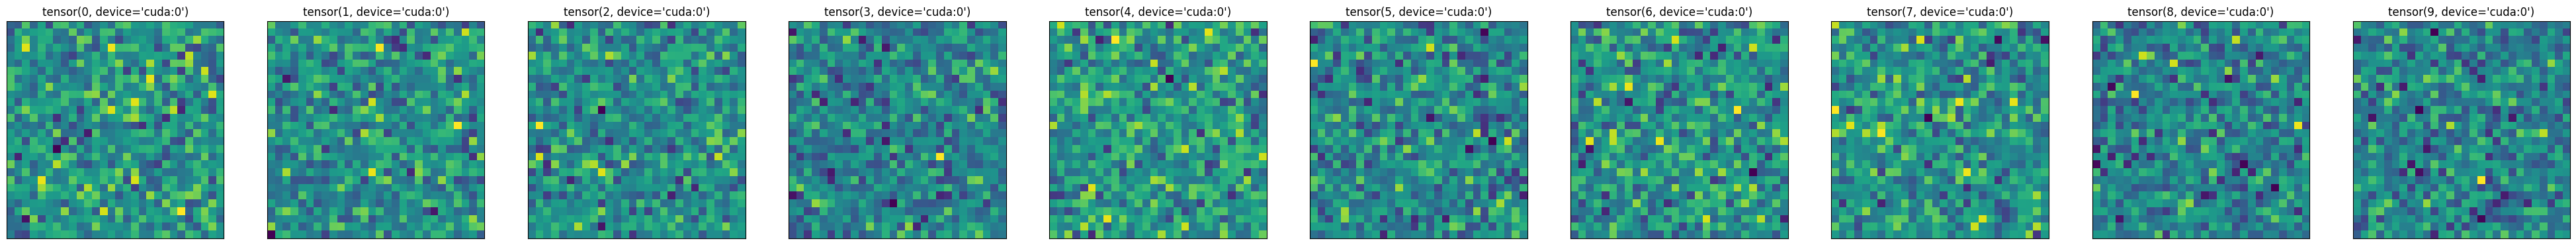

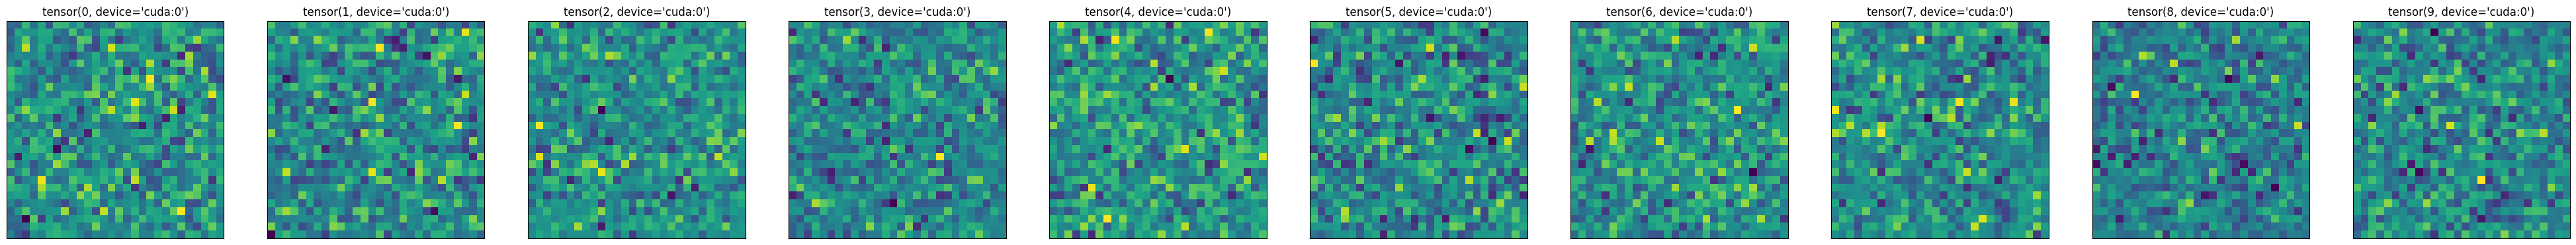

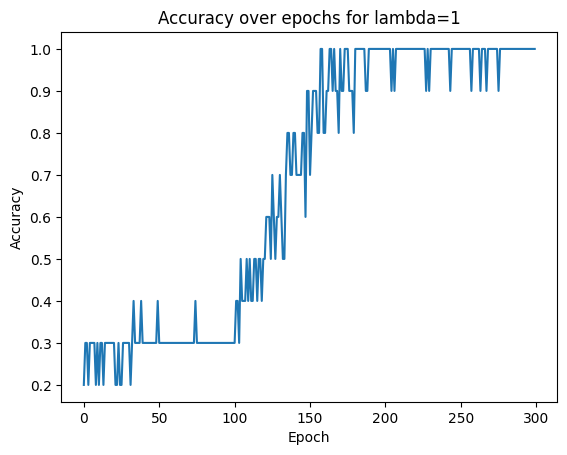

In [58]:
net.to(device)
net.requires_grad= False
labels=torch.tensor([0,1,2,3,4,5,6,7,8,9])

lambdas_l2=[0.001,0.01,0.1,1,10]

starting_inputs=torch.randn((10,1,28,28))

for lambda_l2 in lambdas_l2:

  noised_inputs=starting_inputs.clone()
  noised_inputs = noised_inputs.to(device)
  noised_inputs.requires_grad = True
  labels = labels.to(device)
  optimizer = torch.optim.Adam([noised_inputs], 0.001)   #initial and fixed learning rate of 0.001.


  accuracy=[]

  display_numbers(starting_inputs.cpu().detach().numpy())

  for epoch in range(300):  #  an epoch is a training run through the whole data set

      optimizer.zero_grad()

      batch_outputs = net(noised_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
      loss = torch.nn.functional.cross_entropy(batch_outputs, labels, reduction = "mean")+lambda_l2 * noised_inputs.pow(2).mean() #instead, nonlinear softmax is applied internally in THIS loss function
      loss.backward()       #this computes gradients as we have seen in previous workshops
      optimizer.step()

      good=0
      wrong=0
      with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
        for i in range(10): #batches in test are of size 1
          datapoint= noised_inputs[i]
          datapoint=datapoint.unsqueeze_(0)
          label = labels[i]

          prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
          classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

          if classification.item() == label.item():
            good += 1
          else:
            wrong += 1
      accuracy.append(good/(good+wrong))
  display_numbers(noised_inputs.cpu().detach().numpy())
  plt.show()
  plt.plot(accuracy)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title(f'Accuracy over epochs for lambda={lambda_l2}')
  plt.show()

What is intresting acurracy doesn't always grow like in MLP. We might think that is because image doesn't overfit to model. But still we can't number that the image is representing.

These jumps in accuracy are effects of max pooling. Change in the maximum node in window can change the maximum node. This affects results more strongly than change within node itself.

### Task 2

In [61]:
import numpy as np
# We sample 9 digits from every class
found_digits=[0 for _ in range(10)]
samples=np.zeros((90,28,28))
targets=[]
dlugosc=len(trainset)
i=0
while len(samples)<90:
  sample=np.random.randint(0,dlugosc)
  label=trainset.targets[sample].item()
  if found_digits[label]<9:
    samples[i,:,:]=trainset.data[sample].numpy()
    found_digits[label]+=1
    targets.append(label)
    i+=1



torch.Size([90, 28, 28])

ValueError: cannot select an axis to squeeze out which has size not equal to one

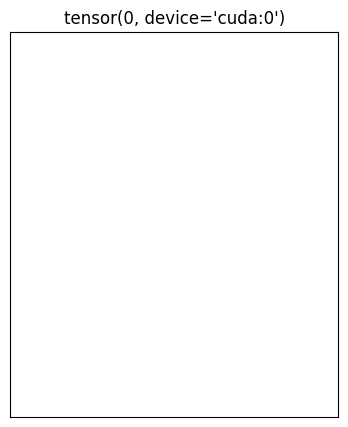

In [62]:
net.to(device)
net.requires_grad= False

lambdas_l2=[1]

delta=torch.randn((1,28,28))


for lambda_l2 in lambdas_l2:

  samples = samples.to(device)
  targets = targets.to(device)
  optimizer = torch.optim.Adam([delta], 0.001)   #initial and fixed learning rate of 0.001.

  display_numbers(samples[:10].cpu().detach().numpy())


  accuracy=[]

  for epoch in range(300):  #  an epoch is a training run through the whole data set

      optimizer.zero_grad()

      batch_outputs = net(samples+delta)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
      loss = -torch.nn.functional.cross_entropy(batch_outputs, labels, reduction = "mean")+lambda_l2 * delta.pow(2).mean() #instead, nonlinear softmax is applied internally in THIS loss function
      loss.backward()       #this computes gradients as we have seen in previous workshops
      optimizer.step()

      good=0
      wrong=0
      with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
        for i in range(10): #batches in test are of size 1
          datapoint= noised_inputs[i]
          datapoint=datapoint.unsqueeze_(0)
          label = labels[i]

          prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
          classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

          if classification.item() == label.item():
            good += 1
          else:
            wrong += 1
      accuracy.append(good/(good+wrong))
  display_numbers(samples[:10].cpu().detach().numpy())
  plt.show()
  plt.plot(accuracy)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title(f'Accuracy over epochs for lambda={lambda_l2}')
  plt.show()